In [1]:
from pysentimiento import create_analyzer
import pandas as pd
import matplotlib.pyplot as plt
from pysentimiento.preprocessing import preprocess_tweet
import numpy as np

df = pd.read_csv("../Datos/comentarios.csv")

C:\Users\Rodrigo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
analyzer = create_analyzer(task="sentiment", lang="es")

def aplicar_analyzer(texto):
    resultado = analyzer.predict(texto)
    return {
        'POS': resultado.probas.get('POS', 0),  # Obtener la probabilidad de POS o 0 si no está presente
        'NEU': resultado.probas.get('NEU', 0),  # Obtener la probabilidad de NEU o 0 si no está presente
        'NEG': resultado.probas.get('NEG', 0)   # Obtener la probabilidad de NEG o 0 si no está presente
    }

C:\Users\Rodrigo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\accelerate\accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


In [3]:

def limpiar_comentario(comentario):
    return preprocess_tweet(comentario, lang="es")

df['post_limpio'] = df['post'].apply(limpiar_comentario)

In [4]:
df[['POS_proba', 'NEU_proba', 'NEG_proba']] = df['post_limpio'].apply(aplicar_analyzer).apply(pd.Series)


In [5]:
df['sentimiento'] = df[['POS_proba', 'NEU_proba', 'NEG_proba']].apply(lambda x: np.argmax(x), axis=1)

# Mapear los valores de índice a etiquetas de sentimiento (POS, NEU, NEG)
sentimiento_map = {0: 'Positivo', 1: 'Neutro', 2: 'Negativo'}
df['sentimiento'] = df['sentimiento'].map(sentimiento_map)

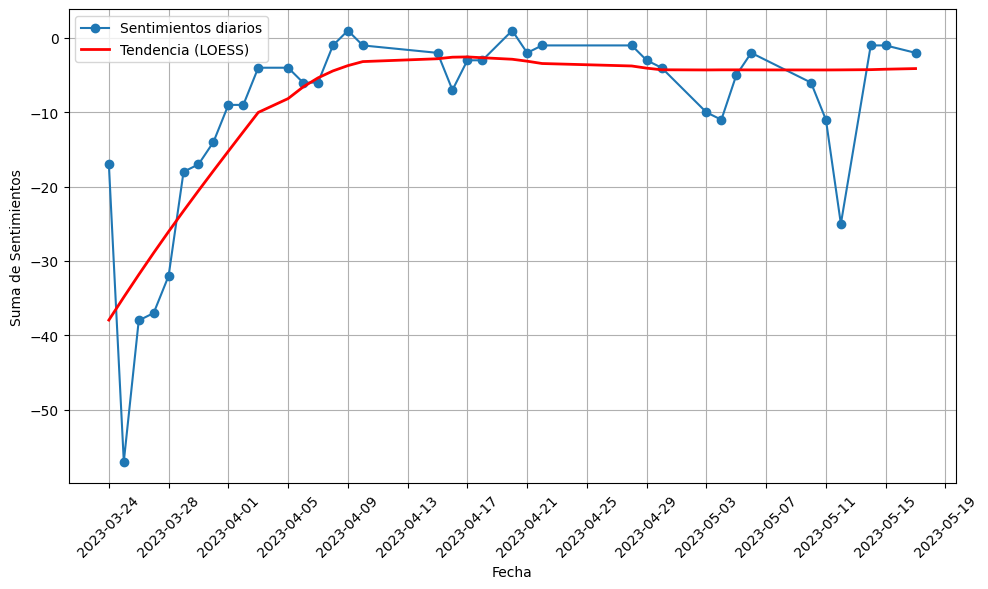

In [8]:
from statsmodels.nonparametric.smoothers_lowess import lowess

# Convertir la columna 'utime' a formato datetime
df['fecha'] = pd.to_datetime(df['utime'], unit='s')

# Filtrar los datos para mantener solo los registros desde marzo de 2023
df = df[df['fecha'] >= '2023-03-01']
df = df[df['fecha'] <= '2023-07-01']

# Agregar una columna de fecha para la agrupación diaria
df['fecha'] = df['fecha'].dt.date

# Asignar valores numéricos a los sentimientos
sentiment_map = {'Positivo': 1, 'Negativo': -1, 'Neutro': 0}
df['sentimiento_val'] = df['sentimiento'].map(sentiment_map)

# Calcular la suma de los sentimientos por día
sentimientos_diarios = df.groupby('fecha')['sentimiento_val'].sum()
# Convertir las fechas a números para la regresión
dates = np.array(sentimientos_diarios.index)
dates_num = np.arange(len(dates))

# Calcular los coeficientes de la regresión lineal
coefficients = np.polyfit(dates_num, sentimientos_diarios.values, 1)
trend = np.poly1d(coefficients)

frac = 0.6  # Fracción de puntos para usar en el ajuste local
loess_smoothed = lowess(sentimientos_diarios.values, dates_num, frac=frac)

# Graficar la evolución de los sentimientos en el tiempo por día
plt.figure(figsize=(10, 6))
plt.plot(dates, sentimientos_diarios, marker='o', label='Sentimientos diarios')
plt.plot(dates, loess_smoothed[:, 1], label='Tendencia (LOESS)', color='red', linewidth=2)  # Línea sólida
plt.xlabel('Fecha')
plt.ylabel('Suma de Sentimientos')
plt.xticks(rotation=45)

# Ajustar los ticks del eje x para que aparezcan cada dos días
locator = plt.gca().xaxis.get_major_locator()
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(nbins=len(dates) // 2))

plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()